In [72]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import io

import matplotlib.font_manager
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import pandas as pd
import plotnine as p
import requests

import warnings
warnings.filterwarnings("ignore")  # plotnine has a lot of MatplotlibDeprecationWarning's

Populating the interactive namespace from numpy and matplotlib


In [411]:
url = "http://nxn.se/single-cell-studies/data.tsv"
df = pd.read_csv(url, sep='\t')

In [412]:
df.shape

(555, 25)

In [75]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

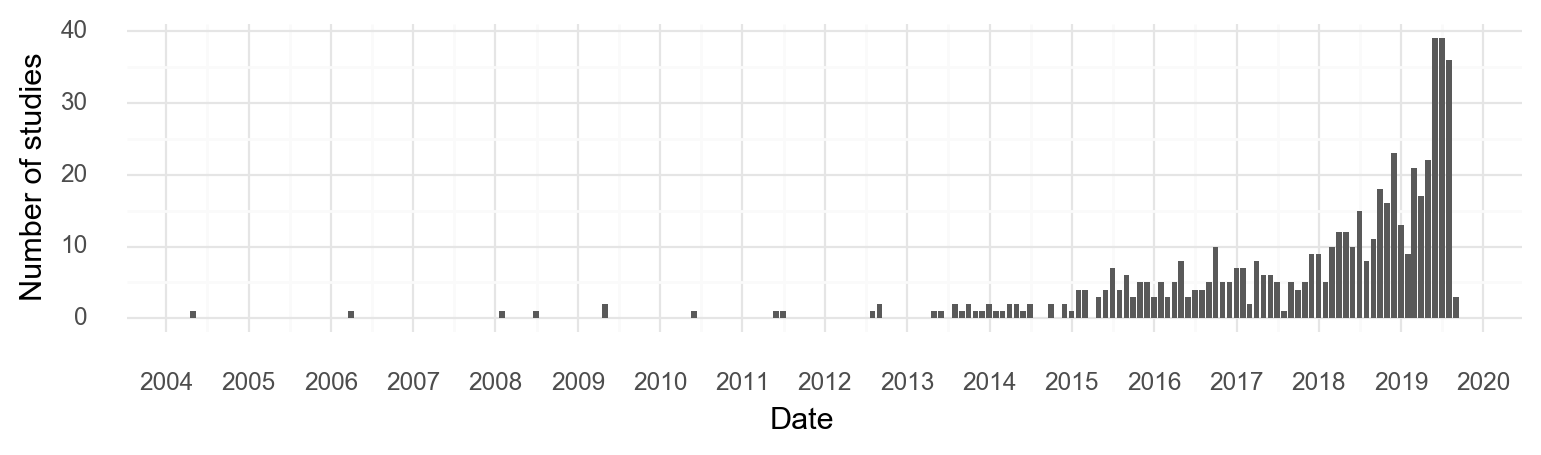

<ggplot: (8789098227376)>

In [76]:
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI'), data=df.resample('1M', on='Date').count()[['DOI']].reset_index())
    + p.geom_bar(stat='identity')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies')
)
fig.save('studies_over_time.pdf')
fig

In [77]:
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    
    return new_df

In [78]:
ts = pd.Timestamp

In [320]:
tdf = tidy_split(df, 'Technique', ' & ')

t_dict = {k: k for k in tdf['Technique'].value_counts().head(5).index}

t_dict

{'Chromium': 'Chromium',
 'Drop-seq': 'Drop-seq',
 'InDrops': 'InDrops',
 'SMARTer (C1)': 'SMARTer (C1)',
 'Smart-seq2': 'Smart-seq2'}

In [321]:
tdf['Technique'] = tdf['Technique'].map(lambda s: t_dict.get(s, 'Other'))

In [322]:
techs = list(
    tdf['Technique']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')

tdf['Technique'] = (
    pd.Categorical(
       tdf['Technique'],
        categories=techs,
        ordered=True
    )
)

In [400]:
import matplotlib.colors as mplcol

def desaturate(color, prop):
    """Decrease the saturation channel of a color by some percent.
    Parameters
    ----------
    color : matplotlib color
        hex, rgb-tuple, or html color name
    prop : float
        saturation channel of color will be multiplied by this value
    Returns
    -------
    new_color : rgb tuple
        desaturated color code in RGB tuple representation
    """
    # Check inputs
#     if not 0 <= prop <= 1:
#         raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mplcol.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
#     l *= prop
    l = 0.8

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)
    
    hex_color = '#{:02x}{:02x}{:02x}'.format(*map(lambda c: int(c * 255), new_color))

    return hex_color


In [401]:
import colorsys

In [402]:
clrs = list(map(lambda c: desaturate(c, 1.2), ['C0', 'C1', 'C2', 'C3', 'C4', 'black']))

In [403]:
clrs

['#a7d2f0', '#ffc899', '#afe9af', '#efa8a9', '#ccb7e0', '#cccccc']

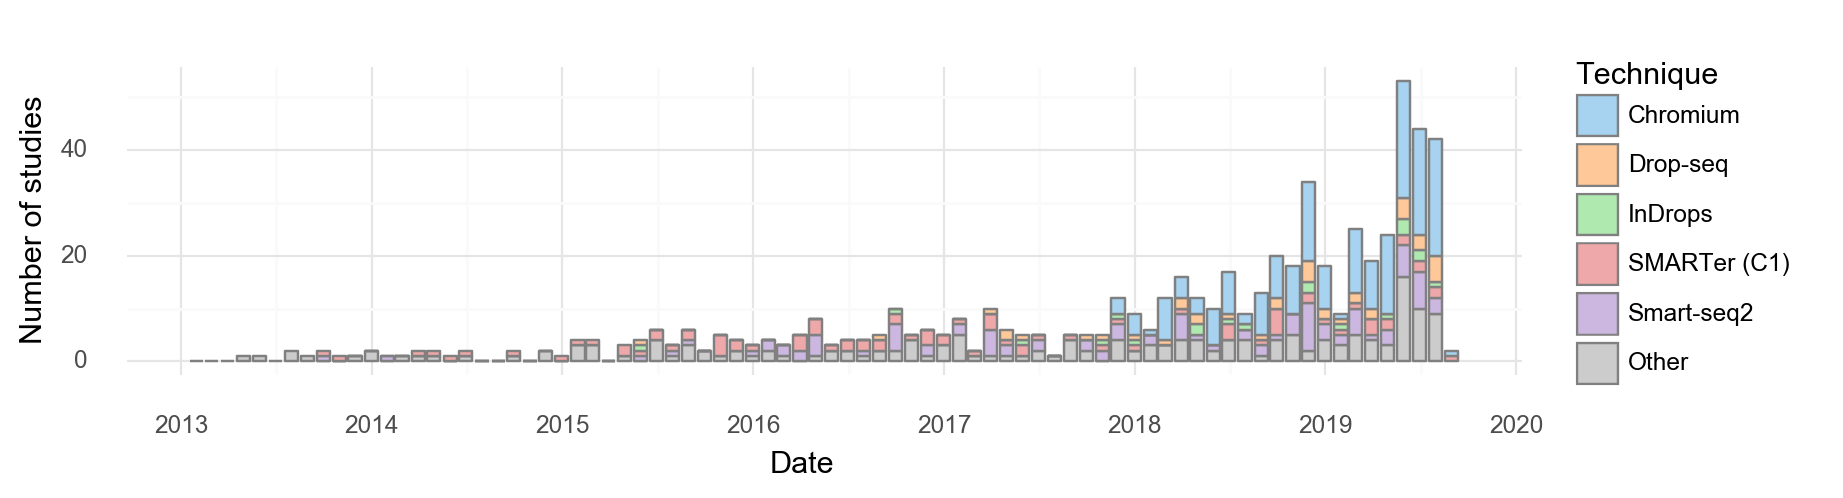

<ggplot: (-9223363247738782520)>

In [404]:
per_month = (
    tdf
    .groupby('Technique')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Technique'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Number of studies')
    + p.scale_fill_manual(clrs)
)
fig.save('techniques_over_time.pdf')
fig

In [83]:
tdf = df[['Date', 'Cell clustering', 'DOI']].dropna()
tdf['Cell clustering'].value_counts()

Yes    214
No      32
Name: Cell clustering, dtype: int64

In [84]:
cluster_fracs = tdf['Cell clustering'].value_counts()
cluster_fracs['Yes'], cluster_fracs.sum(), cluster_fracs['Yes'] / cluster_fracs.sum()

(214, 246, 0.8699186991869918)

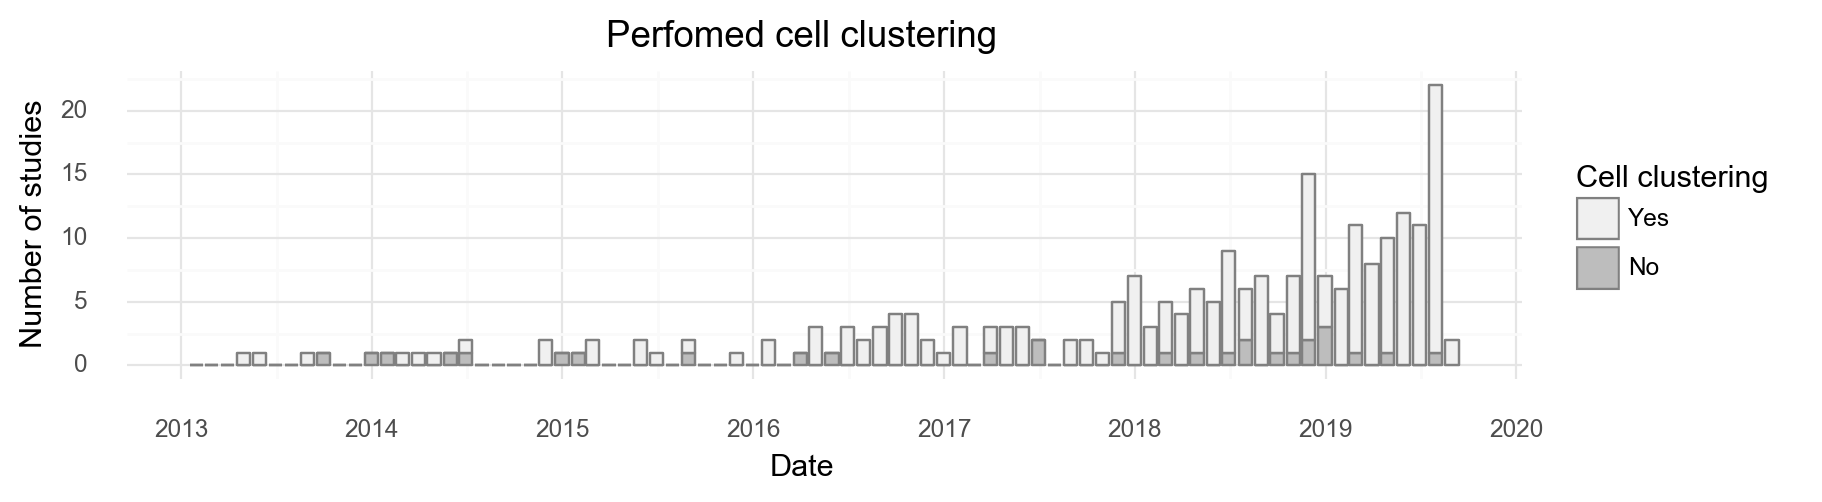

<ggplot: (8789081671572)>

In [85]:
tdf = df[['Date', 'Cell clustering', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('Cell clustering')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['Cell clustering'] = (
    pd.Categorical(
        per_month['Cell clustering'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='Cell clustering'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Perfomed cell clustering')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('clustering_over_time.pdf')
fig

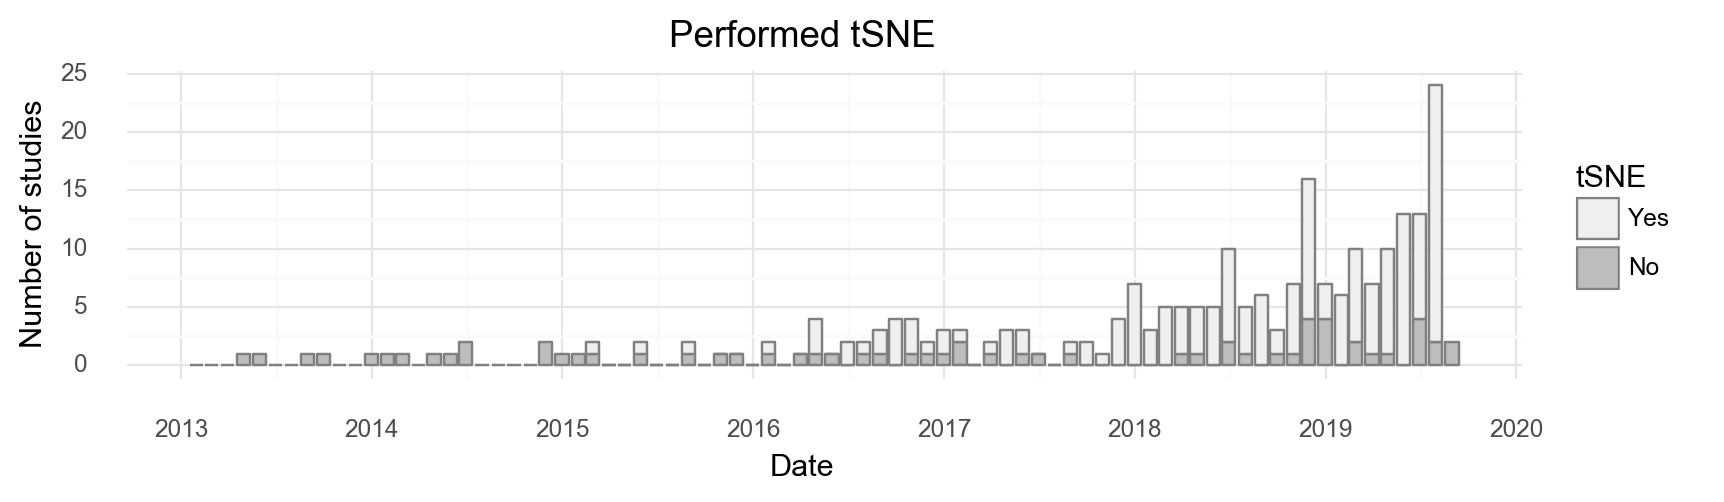

<ggplot: (-9223363247772593639)>

In [86]:
tdf = df[['Date', 'tSNE', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('tSNE')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['tSNE'] = (
    pd.Categorical(
        per_month['tSNE'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI', fill='tSNE'), data=per_month.query('Date > @ts("20130101T010101")'))
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Performed tSNE')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('tsne_over_time.pdf')
fig

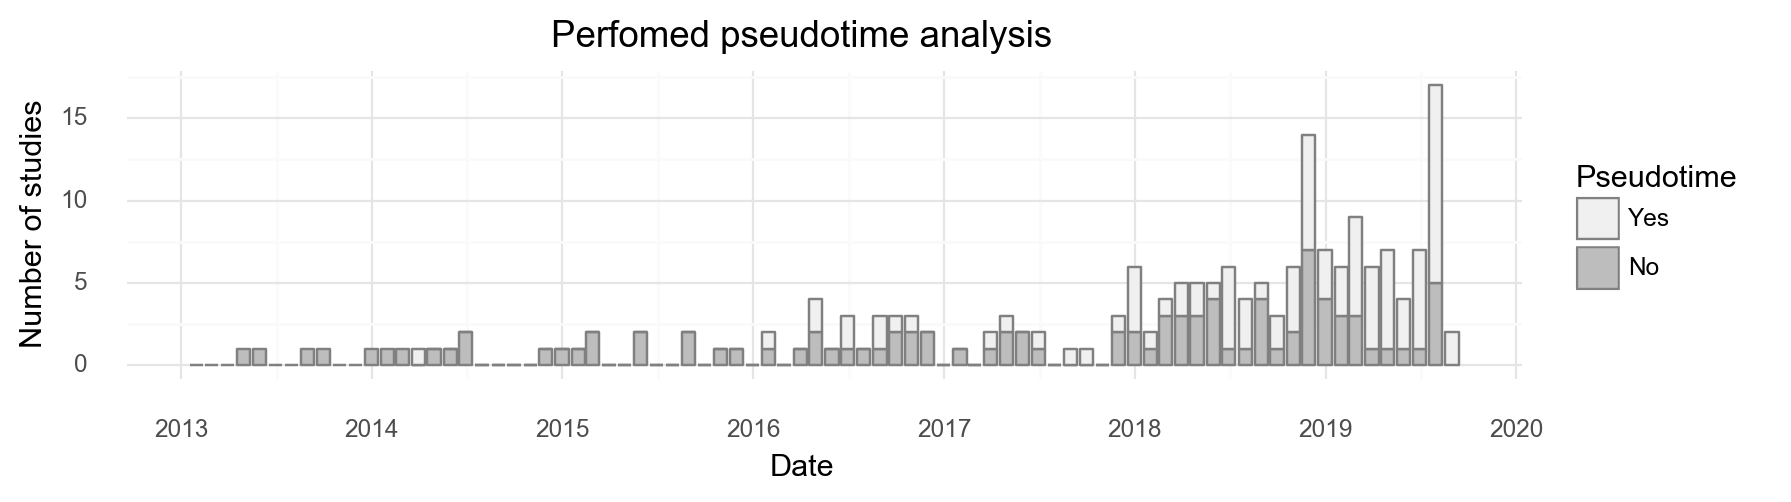

<ggplot: (-9223363247789557479)>

In [87]:
tdf = df[['Date', 'Pseudotime', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('Pseudotime')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['Pseudotime'] = (
    pd.Categorical(
        per_month['Pseudotime'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='DOI', fill='Pseudotime'), data=per_month.query('Date > @ts("20130101T010101")'))
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies', title='Perfomed pseudotime analysis')
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('pseudotime_over_time.pdf')
fig

In [88]:
tdf = tidy_split(df, 'Authors', ', ')
tdf['Authors'].value_counts().head(10)

Aviv Regev               43
Rahul Satija             19
Orit Rozenblatt-Rosen    18
Sarah A. Teichmann       16
Fuchou Tang              14
Alex K. Shalek           13
Danielle Dionne          11
John C. Marioni          11
Sten Linnarsson          11
Berthold Göttgens        10
Name: Authors, dtype: int64

In [89]:
np.unique(tdf['Authors']).shape

(5888,)

In [90]:
df['Journal'].value_counts().head(10)

bioRxiv           63
Nature            50
Cell              49
Cell Reports      35
Science           34
Nat Commun        29
Genome Biol       19
Nat Methods       18
Nat Immunol       16
Cell Stem Cell    16
Name: Journal, dtype: int64

In [91]:
tdf = tidy_split(df, 'Tissue', ', ')
tdf['Tissue'].value_counts().head(10)

Brain             64
Culture           47
Blood             16
Heart             16
Pancreas          16
Embryo            14
Lung              12
Whole organism    10
Bone marrow        9
Skin               9
Name: Tissue, dtype: int64

In [92]:
df.head().T

,0,1,2,3,4
Shorthand,Tietjen et al Neuron,Kurimoto et al NAR,Esumi et al NResearch,Subkhankulova et al BMCGenomics,Tang et al NMeth
DOI,10.1016/S0896-6273(03)00229-0,10.1093/nar/gkl050,10.1016/j.neures.2007.12.011,10.1186/1471-2164-9-268,10.1038/NMETH.1315
Authors,"Ian Tietjen, Jason M. Rihel, Yanxiang Cao, Geo...",K. Kurimoto,"Shigeyuki Esumi, Sheng-Xi Wu, Yuchio Yanagawa,...","Tatiana Subkhankulova, Michael J Gilchrist, Fr...","Fuchou Tang, Catalin Barbacioru, Yangzhou Wang..."
Journal,Neuron,Nucleic Acids Research,Neuroscience Research,BMC Genomics,Nat Methods
Title,Single-Cell Transcriptional Analysis of Neuron...,An improved single-cell cDNA amplification met...,Method for single-cell microarray analysis and...,Modelling and measuring single cell RNA expres...,mRNA-Seq whole-transcriptome analysis of a sin...
Date,2004-04-15 00:00:00,2006-03-30 00:00:00,2008-01-07 00:00:00,2008-06-13 00:00:00,2009-04-06 00:00:00
bioRxiv DOI,-,-,-,-,-
Reported cells total,37,20,8,12,5
Technique,PCR,aRNA amplification,Super SMART,PCR,Tang
Data location,NaN,GSE4309,NaN,NaN,GSE14605


In [93]:
(df['bioRxiv DOI'] != '-').value_counts()

False    410
True     145
Name: bioRxiv DOI, dtype: int64

In [94]:
df['did_bioRxiv'] = (df['bioRxiv DOI'] != '-').map({True: 'Yes', False: 'No'})

In [95]:
cluster_fracs = df['did_bioRxiv'].value_counts()
cluster_fracs['Yes'], cluster_fracs.sum(), cluster_fracs['Yes'] / cluster_fracs.sum()

(145, 555, 0.26126126126126126)

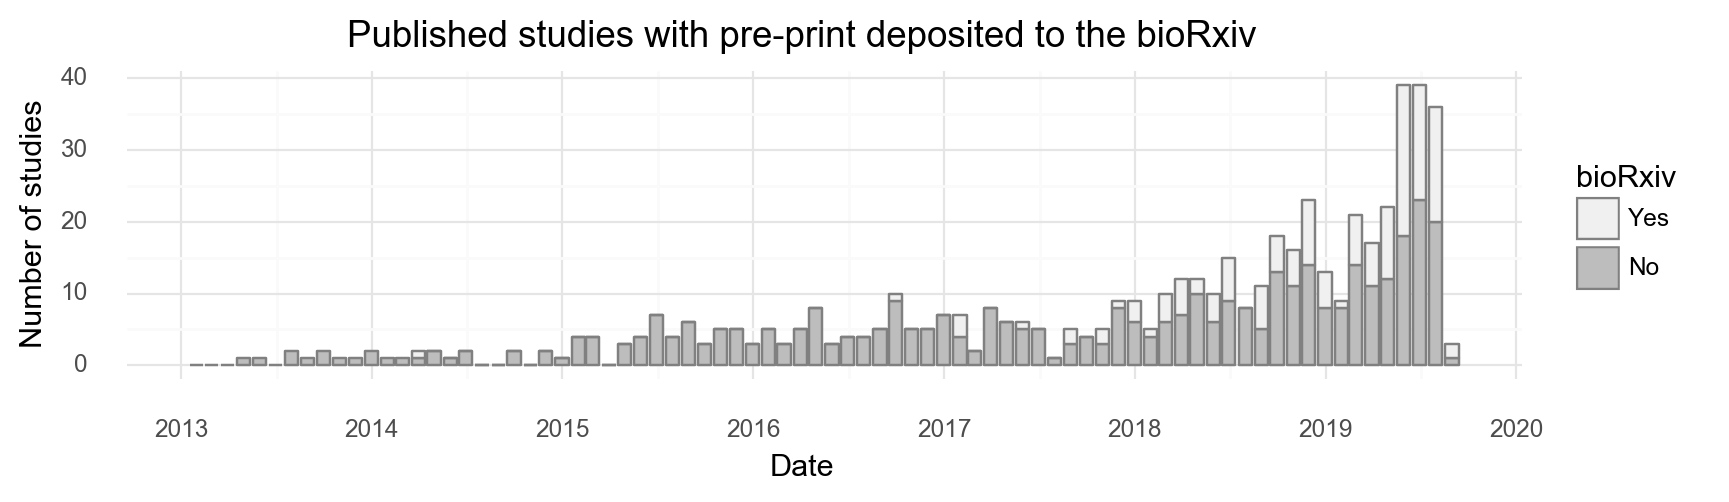

<ggplot: (-9223363247789125425)>

In [408]:
tdf = df[['Date', 'did_bioRxiv', 'DOI']].dropna()
tdf['Date'] = pd.to_datetime(tdf['Date'], format='%Y%m%d')
per_month = (
    tdf
    .groupby('did_bioRxiv')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
per_month['did_bioRxiv'] = (
    pd.Categorical(
        per_month['did_bioRxiv'],
        categories=['Yes', 'No'],
        ordered=True
    )
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='DOI', fill='did_bioRxiv'),
        data=per_month.query('Date > @ts("20130101T010101")')
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(
        y='Number of studies',
        title='Published studies with pre-print deposited to the bioRxiv',
        fill='bioRxiv'
    )
    + p.scale_fill_brewer(palette='Greys')
)
fig.save('biorxiv_over_time.pdf')
fig

In [97]:
(
    per_month
    .pivot(index='Date', columns='did_bioRxiv', values='DOI')
    .fillna(0)
    .sort_index(ascending=False)
    .head(10)
)

did_bioRxiv,Yes,No
Date,,
2019-08-31,2.0,1.0
2019-07-31,16.0,20.0
2019-06-30,16.0,23.0
2019-05-31,21.0,18.0
2019-04-30,10.0,12.0
2019-03-31,6.0,11.0
2019-02-28,7.0,14.0
2019-01-31,1.0,8.0
2018-12-31,5.0,8.0


In [98]:
df['Reported cells total'] = df['Reported cells total'].str.replace(',', '').map(float)

In [99]:
df.Measurement.unique()

array(['Microarray', 'RNA-seq', 'In Situ', nan], dtype=object)

In [269]:
df.Measurement = pd.Categorical(
    df.Measurement,
    categories=['RNA-seq', 'In Situ', 'Microarray'],
    ordered=True
)

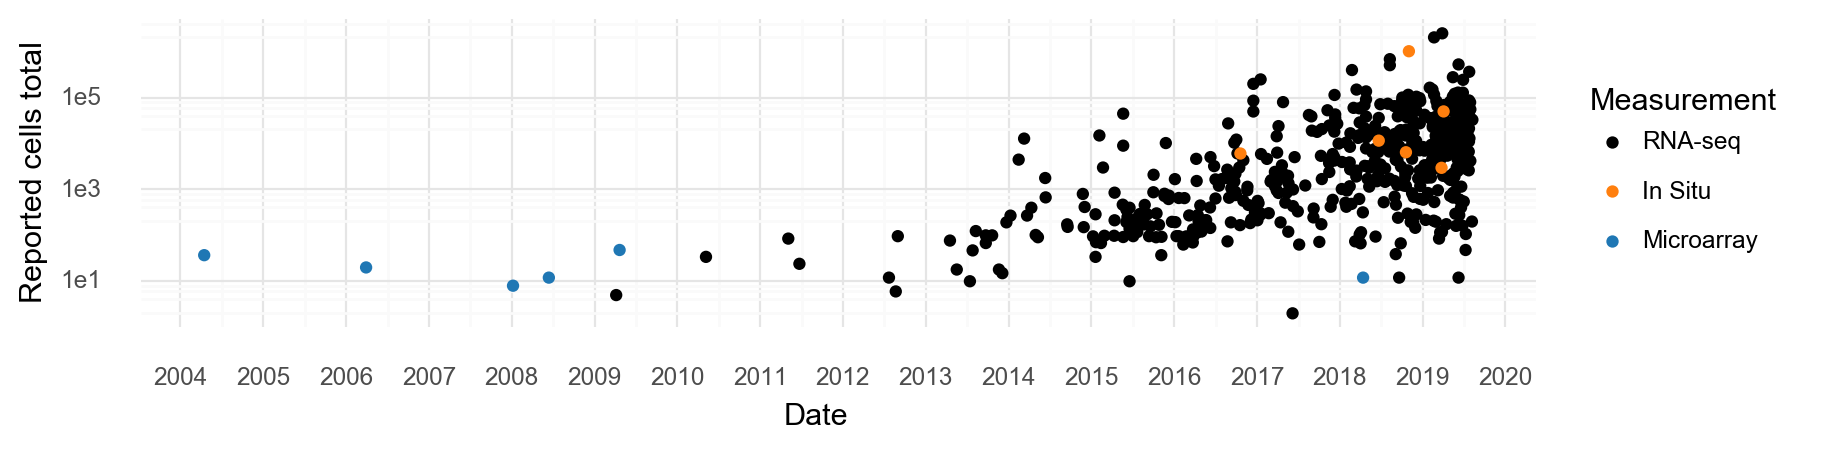

<ggplot: (8789082722813)>

In [284]:
m_idx = df['Measurement'].value_counts().index

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes( x='Date', y='Reported cells total', color='Measurement'), 
        data=df.query('Measurement in @m_idx')
    )
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.scale_color_manual(['black', 'C1', 'C0'])
)
fig.save('all_studies.pdf')
fig

In [102]:
df['Tech'] = df['Technique'].map(lambda s: t_dict.get(s, 'Other'))

techs = list(
    df['Tech']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')

df['Tech'] = (
    pd.Categorical(
       df['Tech'],
        categories=techs,
        ordered=True
    )
)

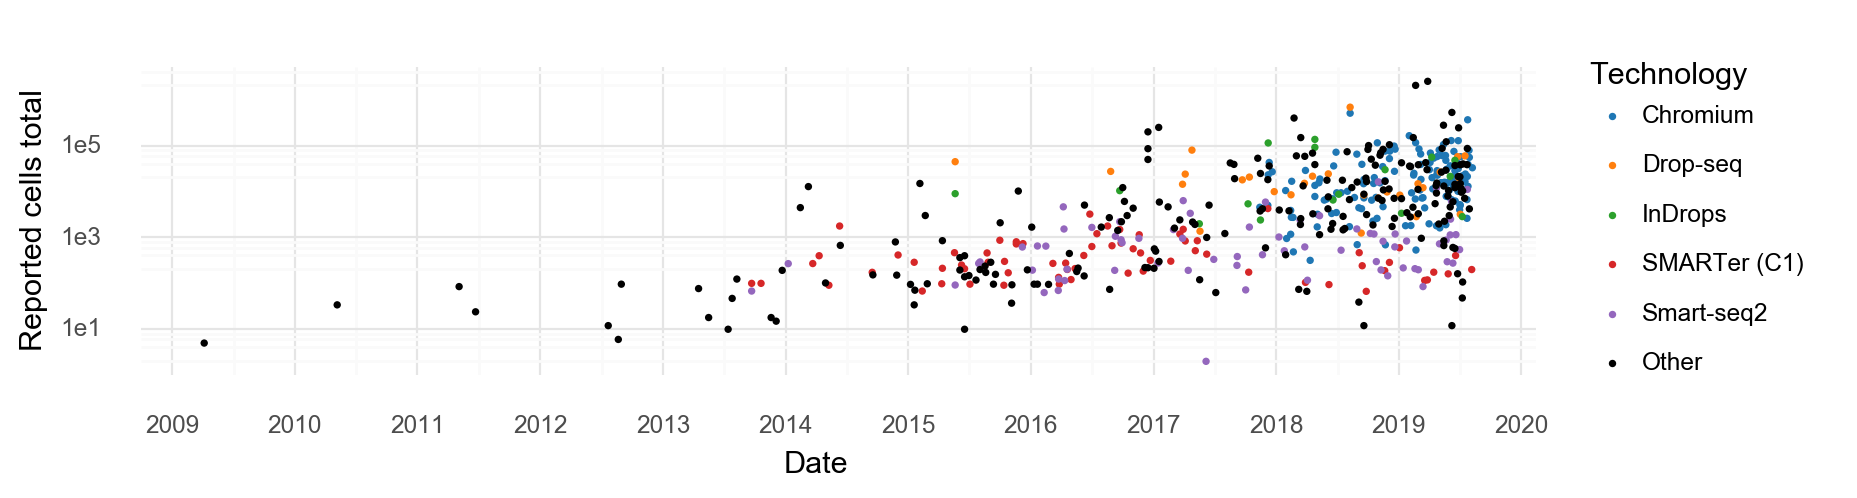

<ggplot: (8789082668797)>

In [318]:
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        p.aes(x='Date', y='Reported cells total', fill='Tech'),
        data=df.query('Measurement == "RNA-seq"')
    )
    + p.geom_point(alpha=1, color='none', size=1)
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.scale_fill_manual(['C0', 'C1', 'C2', 'C3', 'C4', 'black'])
    + p.labs(fill='Technology')
)
fig.save('scrnaseq-_studies.pdf')
fig

In [32]:
(
    df
    .query('Measurement == "RNA-seq"')
    .resample('1M', on='Date')
    .median()
    .tail(7)
)

,Reported cells total,Number of reported cell types or clusters
Date,,
2019-02-28,11175.0,12.0
2019-03-31,11452.0,22.0
2019-04-30,17725.5,10.5
2019-05-31,14585.0,13.5
2019-06-30,15000.0,12.0
2019-07-31,13966.0,15.5
2019-08-31,16600.0,4.0


In [406]:
(
    df
    .query('Measurement == "RNA-seq"')
    .resample('1M', on='Date')
    .count()
    .tail(8)[['DOI']]
)

,DOI
Date,
2019-01-31,9
2019-02-28,21
2019-03-31,16
2019-04-30,21
2019-05-31,39
2019-06-30,39
2019-07-31,36
2019-08-31,2


In [34]:
df.query('Measurement == "RNA-seq" and Date > @ts("20190101T010101")').median()

Reported cells total                         13374.0
Number of reported cell types or clusters       12.0
dtype: float64

In [407]:
df.query('Measurement == "RNA-seq"').resample('1M', on='Date').median().tail(8)

,Reported cells total,Number of reported cell types or clusters
Date,,
2019-01-31,3368.0,8.0
2019-02-28,11175.0,12.0
2019-03-31,11452.0,22.0
2019-04-30,17725.5,10.5
2019-05-31,14585.0,13.5
2019-06-30,15000.0,12.0
2019-07-31,13966.0,15.5
2019-08-31,16600.0,4.0


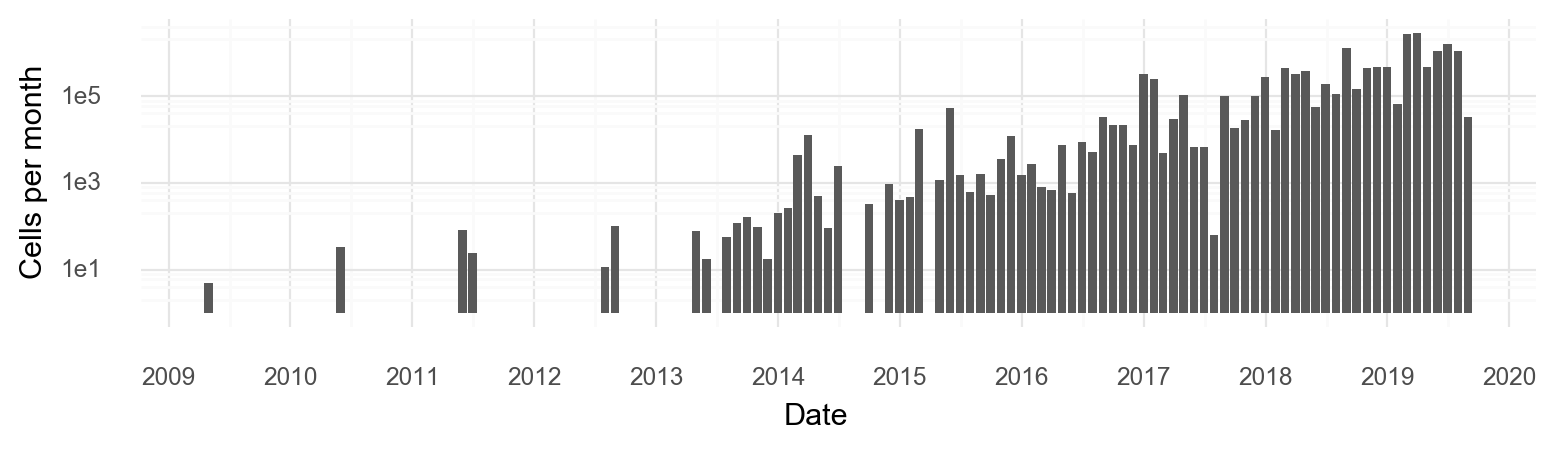

<ggplot: (8789082182429)>

In [36]:
test = df.query('Measurement == "RNA-seq"').resample('M', on='Date').sum().reset_index()
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='Reported cells total'), data=test.query('`Reported cells total` > 0'))
    + p.geom_bar(stat='identity')
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Cells per month')
)
fig.save('cells_per_month.pdf')
fig

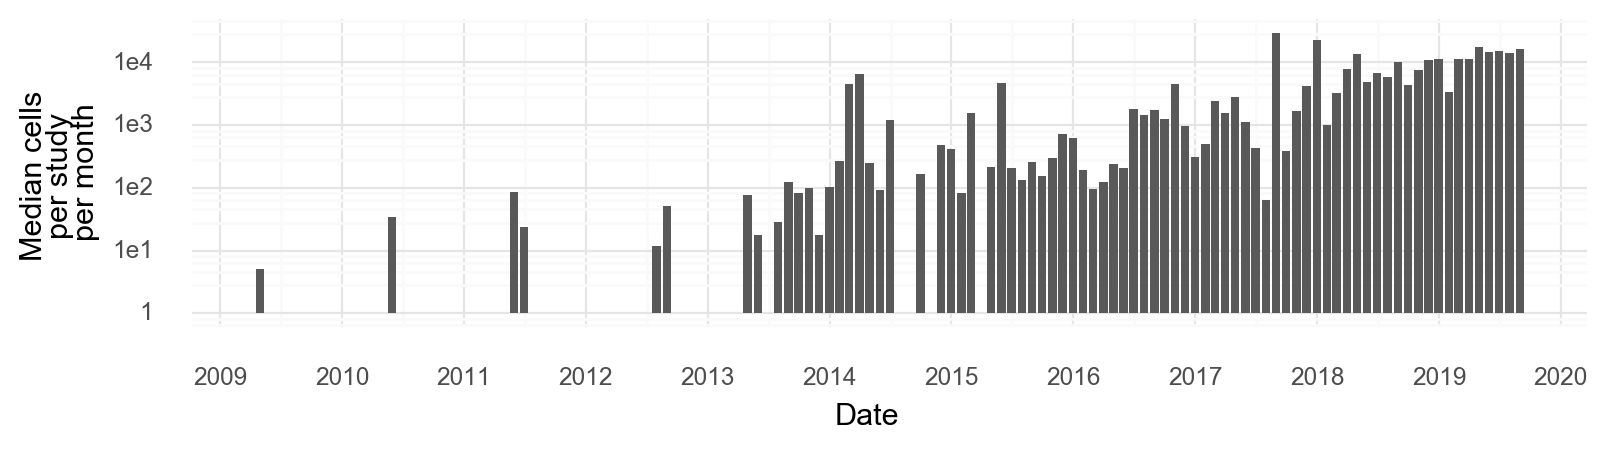

<ggplot: (-9223363247772548906)>

In [37]:
test = df.query('Measurement == "RNA-seq"').resample('1M', on='Date').median().reset_index()
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(p.aes(x='Date', y='Reported cells total'), data=test.query('`Reported cells total` > 0'))
    + p.geom_bar(stat='identity')
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Median cells \nper study \nper month')
)
fig

In [38]:
df.head().T

,0,1,2,3,4
Shorthand,Tietjen et al Neuron,Kurimoto et al NAR,Esumi et al NResearch,Subkhankulova et al BMCGenomics,Tang et al NMeth
DOI,10.1016/S0896-6273(03)00229-0,10.1093/nar/gkl050,10.1016/j.neures.2007.12.011,10.1186/1471-2164-9-268,10.1038/NMETH.1315
Authors,"Ian Tietjen, Jason M. Rihel, Yanxiang Cao, Geo...",K. Kurimoto,"Shigeyuki Esumi, Sheng-Xi Wu, Yuchio Yanagawa,...","Tatiana Subkhankulova, Michael J Gilchrist, Fr...","Fuchou Tang, Catalin Barbacioru, Yangzhou Wang..."
Journal,Neuron,Nucleic Acids Research,Neuroscience Research,BMC Genomics,Nat Methods
Title,Single-Cell Transcriptional Analysis of Neuron...,An improved single-cell cDNA amplification met...,Method for single-cell microarray analysis and...,Modelling and measuring single cell RNA expres...,mRNA-Seq whole-transcriptome analysis of a sin...
Date,2004-04-15 00:00:00,2006-03-30 00:00:00,2008-01-07 00:00:00,2008-06-13 00:00:00,2009-04-06 00:00:00
bioRxiv DOI,-,-,-,-,-
Reported cells total,37,20,8,12,5
Technique,PCR,aRNA amplification,Super SMART,PCR,Tang
Data location,NaN,GSE4309,NaN,NaN,GSE14605


In [147]:
reflines

,x,y
0,1000.0,10.0
1,100000.0,100.0
2,1000000.0,1000.0


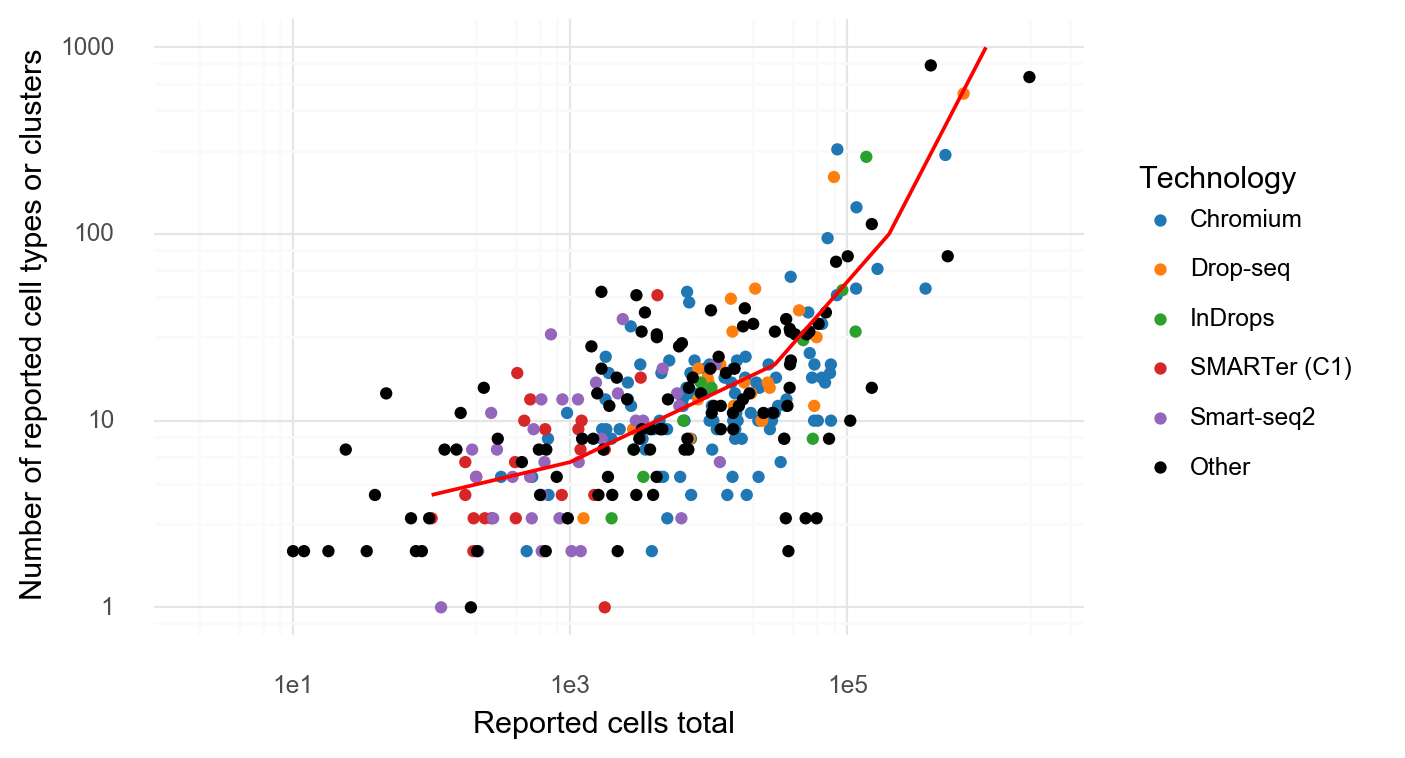

<ggplot: (8789082572285)>

In [405]:
reflines = pd.DataFrame(
    {
        'x': [1e2, 1e3, 3e4, 2e5, 1e6],
        'y': [4e0, 6e0, 2e1, 1e2, 1e3],
        'Tech': ['Other'] * 5
    }
)

p.options.figure_size = (6, 4)
fig = (
    p.ggplot(
        p.aes(
            x='Reported cells total',
            y='Number of reported cell types or clusters',
            fill='Tech'
        ),
        data=df.query('Measurement == "RNA-seq"')
    )
    + p.geom_point(alpha=1, color='none', size=2)
    + p.scale_x_log10()
    + p.scale_y_log10()
    + p.theme_minimal(base_family='Arial')
    + p.scale_fill_manual(['C0', 'C1', 'C2', 'C3', 'C4', 'black'])
    + p.labs(fill='Technology')
    + p.geom_line(
        mapping=p.aes(x='x', y='y'),
        data=reflines,
        color='r',
        size=0.75
    )
)
fig.save('clusters_per_cells.pdf')
fig

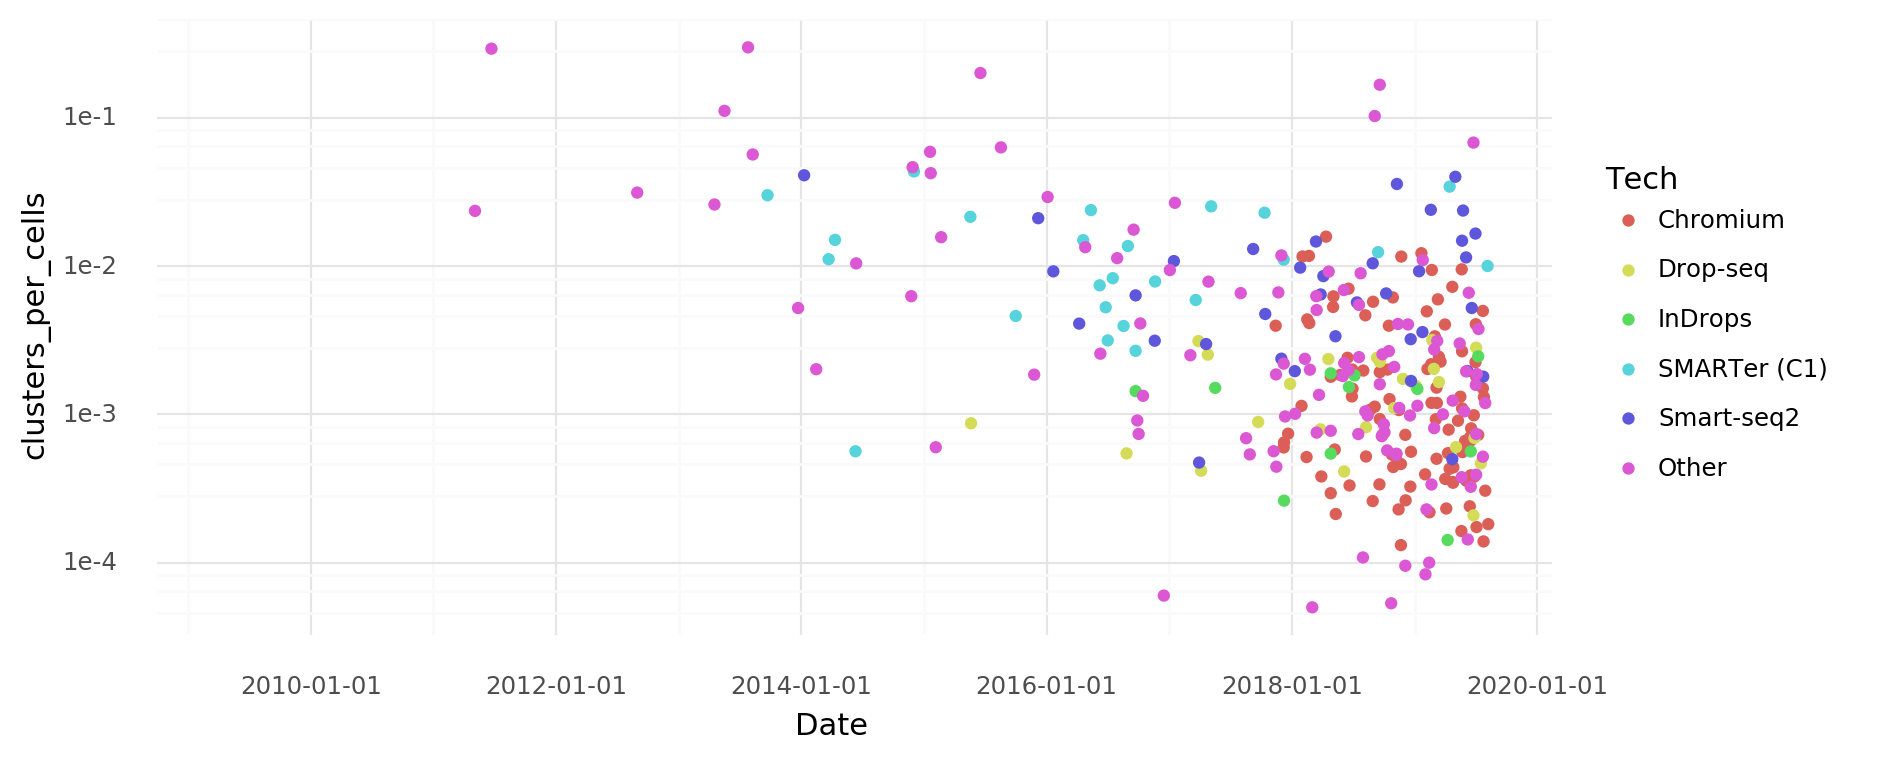

<ggplot: (8789082098531)>

In [40]:
df['clusters_per_cells'] = df['Number of reported cell types or clusters'] / df['Reported cells total']

p.options.figure_size = (9, 4)
(
    p.ggplot(p.aes(x='Date', y='clusters_per_cells', color='Tech'), data=df.query('Measurement == "RNA-seq"'))
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal()
)

In [41]:
df['num_authors'] = df['Authors'].str.split(',').str.len()

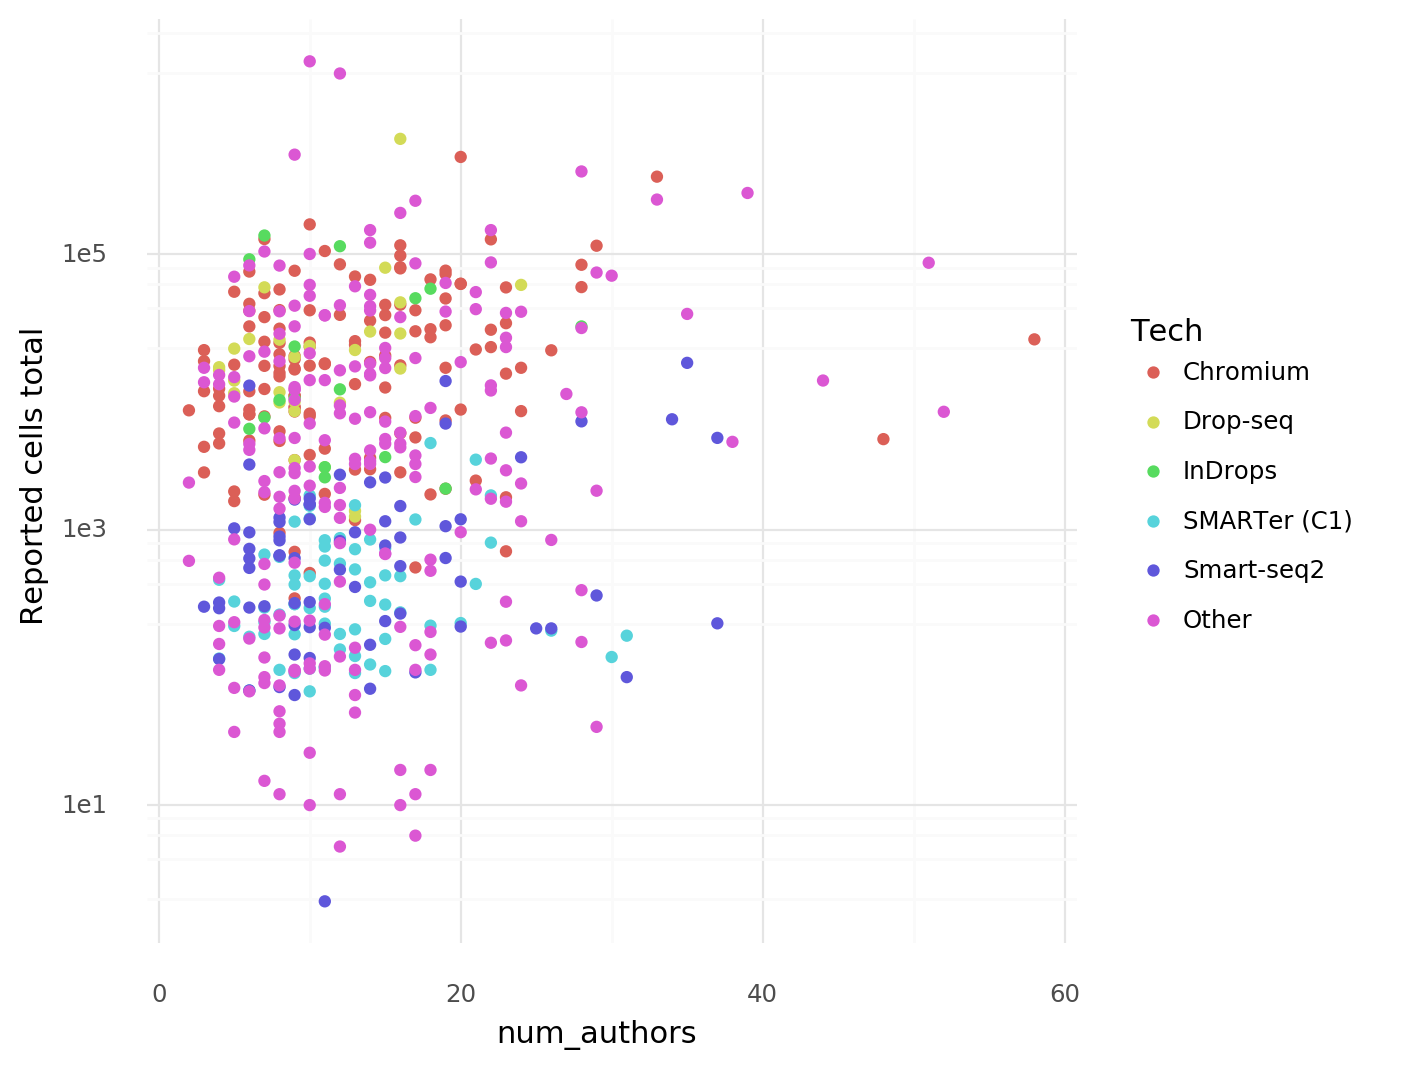

<ggplot: (-9223363247772688959)>

In [42]:
p.options.figure_size = (6, 6)
(
    p.ggplot(p.aes(x='num_authors', y='Reported cells total', color='Tech'), data=df.query('Measurement == "RNA-seq"'))
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal()
)

In [43]:
df['cells_per_author'] = df['Reported cells total'] / df['num_authors']

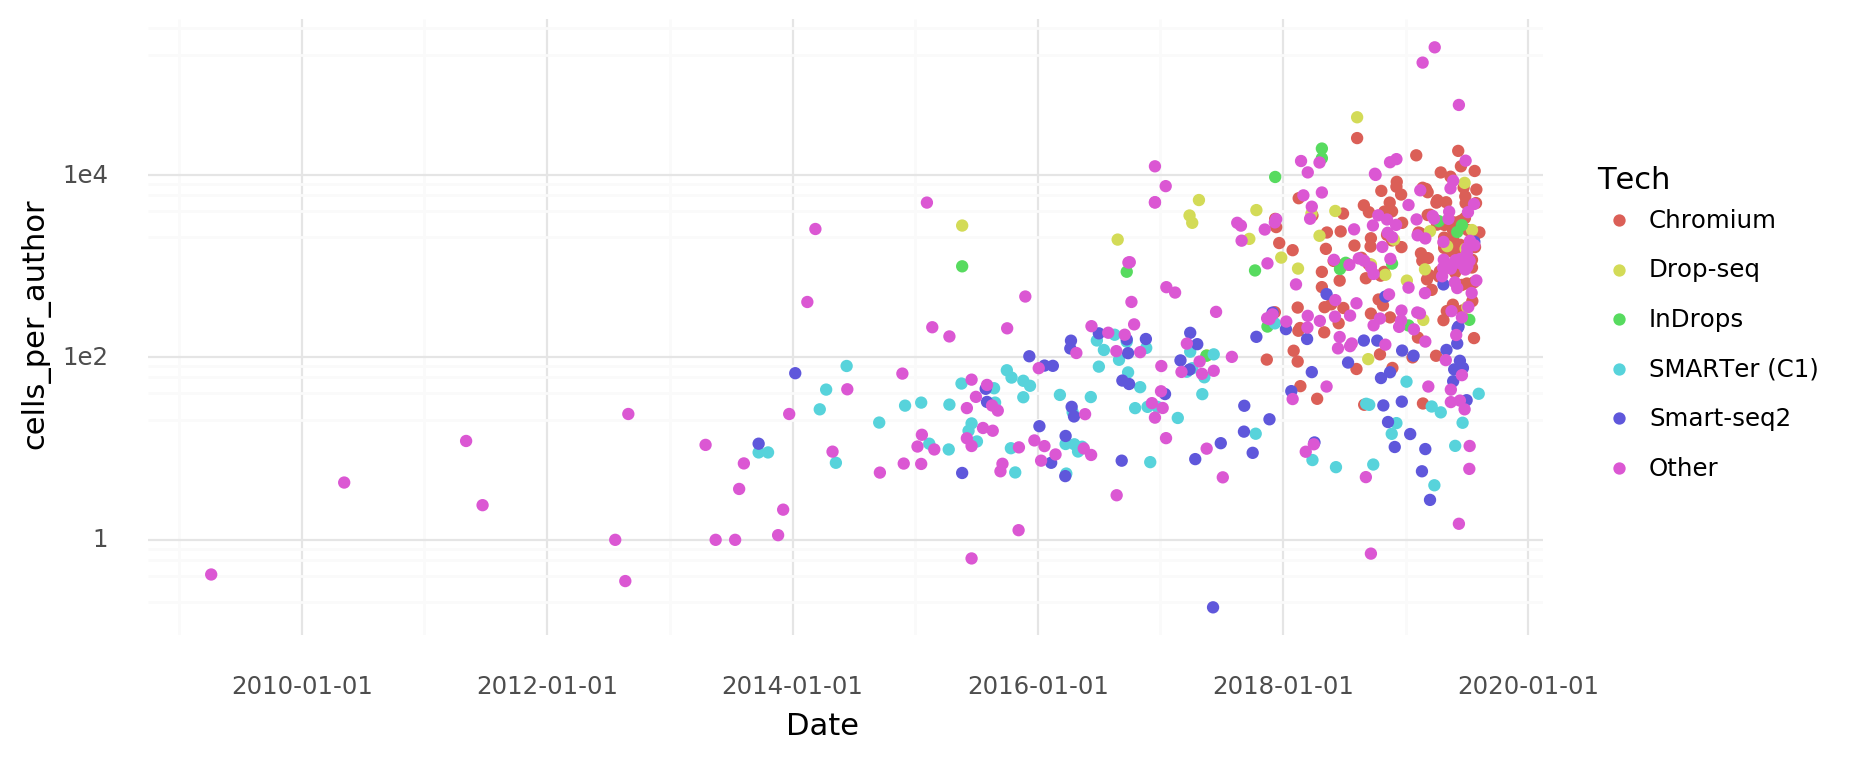

<ggplot: (-9223363247772080461)>

In [44]:
p.options.figure_size = (9, 4)
(
    p.ggplot(p.aes(x='Date', y='cells_per_author', color='Tech'), data=df.query('Measurement == "RNA-seq"'))
    + p.geom_point()
    + p.scale_y_log10()
    + p.theme_minimal()
)

In [45]:
df.query('tSNE == "Yes"').sort_values('Date').head()

,Shorthand,DOI,Authors,Journal,Title,Date,bioRxiv DOI,Reported cells total,Technique,Data location,...,RNA Velocity,PCA,tSNE,H5AD location,Isolation,did_bioRxiv,Tech,clusters_per_cells,num_authors,cells_per_author
43,Zeisel et al,10.1126/science.aaa1934,"A. Zeisel, A. B. Munoz-Manchado, S. Codeluppi,...",Science,Cell types in the mouse cortex and hippocampus...,2015-02-21,-,3005.0,STRT-Seq (C1),GSE60361,...,NaN,Yes,Yes,NaN,IFC Capture,No,Other,0.015641,14,214.642857
50,Macosco et al,10.1016/j.cell.2015.05.002,"Evan Z. Macosko, Anindita Basu, Rahul Satija, ...",Cell,Highly Parallel Genome-wide Expression Profili...,2015-05-21,-,44808.0,Drop-seq,GSE63473,...,No,Yes,Yes,NaN,Nanodroplet dilution,No,Drop-seq,0.000870,16,2800.500000
65,Grun et al Nature,10.1038/nature14966,"Dominic Grün, Anna Lyubimova, Lennart Kester, ...",Nature,Single-cell messenger RNA sequencing reveals r...,2015-08-18,-,238.0,CEL-seq,NaN,...,No,No,Yes,NaN,NaN,No,Other,0.063025,8,29.750000
89,Macaulay et al CReports,10.1016/j.celrep.2015.12.082,"Iain C. Macaulay, Valentine Svensson, Charlott...",Cell Reports,Single-Cell RNA-Sequencing Reveals a Continuou...,2016-01-21,-,652.0,Smart-seq2,E-MTAB-3947,...,No,No,Yes,NaN,NaN,No,Smart-seq2,0.009202,8,81.500000
98,Tirosh et al Science,10.1126/science.aad0501,"I. Tirosh, B. Izar, S. M. Prakadan, M. H. Wads...",Science,Dissecting the multicellular ecosystem of meta...,2016-04-07,-,4645.0,Smart-seq2,GSE72056,...,No,Yes,Yes,NaN,Sorting (FACS),No,Smart-seq2,0.004090,37,125.540541


In [46]:
df.query('Pseudotime == "Yes"').sort_values('Date').head()

,Shorthand,DOI,Authors,Journal,Title,Date,bioRxiv DOI,Reported cells total,Technique,Data location,...,RNA Velocity,PCA,tSNE,H5AD location,Isolation,did_bioRxiv,Tech,clusters_per_cells,num_authors,cells_per_author
26,Trapnell et al NBT,10.1038/nbt.2859,"Cole Trapnell, Davide Cacchiarelli, Jonna Grim...",Nat Biotechnol,The dynamics and regulators of cell fate decis...,2014-03-23,-,270.0,SMARTer (C1),GSE52529,...,No,NaN,NaN,NaN,IFC Capture,No,SMARTer (C1),0.011111,10,27.000000
89,Macaulay et al CReports,10.1016/j.celrep.2015.12.082,"Iain C. Macaulay, Valentine Svensson, Charlott...",Cell Reports,Single-Cell RNA-Sequencing Reveals a Continuou...,2016-01-21,-,652.0,Smart-seq2,E-MTAB-3947,...,No,No,Yes,NaN,NaN,No,Smart-seq2,0.009202,8,81.500000
99,Petropoulos et al Cell,10.1016/j.cell.2016.03.023,"Sophie Petropoulos, Daniel Edsgärd, Björn Rein...",Cell,Single-Cell RNA-Seq Reveals Lineage and X Chro...,2016-04-09,-,1529.0,Smart-seq2,E-MTAB-3929,...,No,Yes,Yes,NaN,NaN,No,Smart-seq2,NaN,10,152.900000
103,Lacar et al NCommunications,10.1038/ncomms11022,"Benjamin Lacar, Sara B. Linker, Baptiste N. Ja...",Nat Commun,Nuclear RNA-seq of single neurons reveals mole...,2016-04-19,-,201.0,SMARTer (C1),GSE77067,...,No,Yes,No,NaN,NaN,No,SMARTer (C1),0.014925,18,11.166667
109,Treutlein et al Nature,10.1038/nature18323,"Barbara Treutlein, Qian Yi Lee, J. Gray Camp, ...",Nature,Dissecting direct reprogramming from fibroblas...,2016-06-07,-,405.0,SMARTer (C1),GSE67310,...,No,Yes,Yes,NaN,NaN,No,SMARTer (C1),0.007407,11,36.818182
